# Imports

In [47]:
import os
import pickle
from collections import defaultdict
from io import StringIO
from multiprocessing import Pool

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from scipy.optimize import curve_fit
from scipy.stats import linregress
from torch.utils._pytree import tree_flatten, tree_map
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter

from cellarium.ml.data import read_h5ad_file

# Constants

In [76]:
COARSE_TISSUE_LABELS = ["brain", "blood", "small intestine", "kidney", "liver", "lung", "heart"]
HELD_OUT_TYPES = ["held_out", "random_split"]
MODEL_NAMES = ["10M_001_bs1536", "19M_001_bs2048", "30M_001_bs2560", "59M_001_bs3072", "98M_001_bs4608", "146M_001_bs5632"]
SHORT_MODEL_NAMES = ["10M", "19M", "30M", "59M", "98M", "146M"]
PROMPT_SIZES = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# Helper functions

In [25]:
def pade_approx(X, A0, A1, B1):
    return (A0 + A1*X) / (1 + B1*X)

def pade_approx_2(X, A0, A1, A2, B1, B2):
    return (A0 + A1*X + A2*X**2) / (1 + B1*X + B2*X**2)

def robust_fit(T, L, initial_guesses, maxfev=10000):
    best_params = None
    best_rss = np.inf  # Residual sum of squares; lower is better
    # Loop over different initial guess sets
    for guess in initial_guesses:
        try:
            # Try to fit the model
            params, _ = curve_fit(pade_approx_2, T, L, p0=guess, maxfev=maxfev)
            # Compute the predicted values and the RSS
            predicted_L = pade_approx_2(T, *params)
            rss = np.sum((L - predicted_L)**2)
            # If this fit is better, store the parameters and RSS
            if rss < best_rss:
                best_rss = rss
                best_params = params
        except RuntimeError:
            # If the fit fails for these initial parameters, continue to the next guess
            continue
    return best_params, best_rss

class OntologyCoarsener:
    def __init__(
            self,
            coarse_labels: list[str],
            ontology_propagation_resource_dict: dict,
            ontology_benchmarking_resource_dict: dict,
            include_other_node: bool = True,
            check_mutual_exclusivity: bool = True,
            verbose: bool = True,
    ):

        # some labels might map to multiple terms, we catch all of them
        coarse_label_to_term_ids_map = defaultdict(list)
        for coarse_label in coarse_labels:
            for term_id, label in ontology_propagation_resource_dict['ontology_term_id_to_label'].items():
                if label == coarse_label:
                    coarse_label_to_term_ids_map[coarse_label].append(term_id)

        # obtain all descendants of each coarse term
        coarse_label_to_descendants_term_ids_map = defaultdict(set)
        implicated_node_set = set()
        for coarse_label, term_ids in coarse_label_to_term_ids_map.items():
            for term_id in term_ids:
                coarse_label_to_descendants_term_ids_map[coarse_label].add(term_id)
                implicated_node_set.add(term_id)
                if term_id in ontology_benchmarking_resource_dict:
                    coarse_label_to_descendants_term_ids_map[coarse_label].update(
                        ontology_benchmarking_resource_dict[term_id]['all_descendants'])
                    implicated_node_set.update(
                        ontology_benchmarking_resource_dict[term_id]['all_descendants'])
                    
        # obtain all ancestors of each coarse term
        coarse_label_to_ancestors_term_ids_map = defaultdict(set)
        for coarse_label, term_ids in coarse_label_to_term_ids_map.items():
            for term_id in term_ids:
                coarse_label_to_ancestors_term_ids_map[coarse_label].add(term_id)
                implicated_node_set.add(term_id)
                if term_id in ontology_benchmarking_resource_dict:
                    coarse_label_to_ancestors_term_ids_map[coarse_label].update(
                        ontology_benchmarking_resource_dict[term_id]['all_ancestors'])
                    implicated_node_set.update(
                        ontology_benchmarking_resource_dict[term_id]['all_ancestors'])

        # generate an "other" node
        if include_other_node:
            other_nodes = set()
            for term_id in ontology_benchmarking_resource_dict:
                if term_id not in implicated_node_set:
                    other_nodes.add(term_id)
            coarse_label_to_descendants_term_ids_map["other"] = other_nodes

        if verbose:
            print("Number of terms under each coarse label:")
            for coarse_label, descendants_term_ids in coarse_label_to_descendants_term_ids_map.items():
                print(f"- {coarse_label}: {len(descendants_term_ids)}")

        if check_mutual_exclusivity:
            for label1, term_ids1 in coarse_label_to_descendants_term_ids_map.items():
                for label2, term_ids2 in coarse_label_to_descendants_term_ids_map.items():
                    if label1 != label2:
                        intersection_terms = list(term_ids1.intersection(term_ids2))
                        intersection_labels = list(
                            map(ontology_propagation_resource_dict['ontology_term_id_to_label'].get, intersection_terms))
                        assert len(intersection_terms) == 0, \
                            f"{label1} and {label2} are not mutually exclusive. They share: {intersection_labels}"

        # inverse
        fine_term_id_to_coarse_label_map = dict()
        for coarse_label, term_ids in coarse_label_to_descendants_term_ids_map.items():
            for term_id in term_ids:
                fine_term_id_to_coarse_label_map[term_id] = coarse_label

        # all coarse labels
        all_coarse_labels = np.asarray(list(coarse_label_to_descendants_term_ids_map.keys()))

        # bookkeeping
        self.all_coarse_labels = all_coarse_labels
        self.fine_term_id_to_coarse_label_map = fine_term_id_to_coarse_label_map
        self.coarse_label_to_descendants_term_ids_map = coarse_label_to_descendants_term_ids_map
        self.coarse_label_to_ancestors_term_ids_map = coarse_label_to_ancestors_term_ids_map

# Download artifacts

In [ ]:
# run this once to download artifacts
# !mkdir artifacts
# !gcloud storage cp -r gs://cellarium-scratch/cellariumgpt-artifacts/training/transcriptome_completion artifacts/

# Experiment

In [80]:
# import yaml
# import torch

# model_name = "146M_001_bs5632"
# experiment = "prompt_size"
# dataset = "held_out"
# measured_type = "all_measured"
# dadc_limits = torch.load("/mnt/cellariumgpt-training-data/cellariumgpt_validation_set2/shared_meta/limit.pkl")

# config_file = "/mnt/cellariumgpt-xfer/compute_optimal/configs/params_146M_001.yaml"
# with open(config_file, "r") as stream:
#     config = yaml.safe_load(stream)

# # set checkpoint path
# config["ckpt_path"] = "/mnt/cellariumgpt-xfer/compute_optimal/146M_001_bs5632/lightning_logs/version_1/checkpoints/epoch=10-step=78917.ckpt"
# config["seed_everything"] = 3112024
# config["return_predictions"] = False

# # data
# config["data"]["dadc"]["filenames"] = "/mnt/cellariumgpt-training-data/cellariumgpt_validation_set2/extract_files/extract_{1..110}.h5ad"
# config["data"]["dadc"]["limits"] = dadc_limits
# config["data"]["dadc"]["shard_size"] = None
# config["data"]["dadc"]["last_shard_size"] = None
# config["data"]["batch_size"] = 64
# config["data"]["num_workers"] = 4
# config["data"]["persistent_workers"] = True
# config["data"]["train_size"] = None
# config["data"]["val_size"] = None
# config["data"]["pred_size"] = None
# config["data"]["shuffle"] = False
# config["data"]["shuffle_seed"] = 3112024
# config["data"]["drop_last_indices"] = False
# config["data"]["drop_incomplete_batch"] = False
# config["data"]["test_mode"] = False
# config["data"]["prefetch_factor"] = None
# config["data"]["iteration_strategy"] = "same_order"
# config["data"]["batch_keys"]["obs_names_n"] = {"attr": "obs_names"}
# del config["data"]["batch_keys"]["gene_token_ng_dict"]["measured_genes_mask"]

# prompt_sizes = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
# for i in prompt_sizes:
#     # trainer
#     config["trainer"]["callbacks"] = [{
#     "class_path": "cellarium.ml.callbacks.cellarium_gpt_prompt_size.PredictionWriter",
#         "init_args": {
#             "output_dir": f"/mnt/cellariumgpt-training-data/info_theor/{experiment}/{dataset}/{measured_type}/{model_name}/output/prompt_size_{i}",
#             "gzip": False
#         }
#     }]
#     config["trainer"]["devices"] = 8
#     config["trainer"]["default_root_dir"] = f"/mnt/cellariumgpt-training-data/info_theor/{experiment}/{dataset}/{measured_type}/{model_name}"

#     # model
#     config["model"]["is_initialized"] = True
#     config["model"]["cpu_transforms"] = [
#         {
#             "class_path": "cellarium.ml.transforms.cellarium_gpt_tokenizer.CellariumGPTTestTokenizer",
#             "init_args": {
#                 "context_len": 2053 + i,
#                 "gene_downsample_p": 1.0,
#                 "gene_vocab_sizes": {
#                     "assay": 19,
#                     "gene_id": 36601,
#                     "gene_value": 2001,
#                     "suspension_type": 2
#                 },
#                 "max_total_mrna_umis": 100000,
#                 "metadata_vocab_sizes": {
#                     "cell_type": 890,
#                     "development_stage": 191,
#                     "disease": 350,
#                     "sex": 2,
#                     "tissue": 822,
#                 },
#                 "min_total_mrna_umis": 1000,
#                 "ontology_downsample_p": 0.0,
#                 "ontology_infos_path": "/mnt/cellariumgpt-training-data/human_cellariumgpt_v2/shared_meta/ontology_infos.pt",
#                 "metadata_prompt_token_list": [],
#                 "prefix_len": i
#             }
#         }
#     ]
#     new_config_file = f"/mnt/cellariumgpt-training-data/info_theor/{experiment}/{dataset}/{measured_type}/{model_name}/configs/prompt_size_{i}.yaml"
#     with open(new_config_file, "w") as stream:
#         yaml.dump(config, stream)


# Results

In [10]:
# read uberon_propagation_resource.pkl into ontology_propagation_resource_dict
with open("./artifacts/transcriptome_completion/uberon_propagation_resource.pkl", "rb") as f:
    ontology_propagation_resource_dict = pickle.load(f)

# read uberon_benchmarking_resource.pkl into ontology_benchmarking_resource_dict
with open("./artifacts/transcriptome_completion/uberon_benchmarking_resource.pkl", "rb") as f:
    ontology_benchmarking_resource_dict = pickle.load(f)

coarsener = OntologyCoarsener(
    coarse_labels=COARSE_TISSUE_LABELS,
    ontology_propagation_resource_dict=ontology_propagation_resource_dict,
    ontology_benchmarking_resource_dict=ontology_benchmarking_resource_dict,
    include_other_node=True,
)

Number of terms under each coarse label:
- brain: 134
- blood: 4
- small intestine: 18
- kidney: 16
- liver: 5
- lung: 22
- heart: 34
- other: 585


In [3]:
try:
    held_out_obs = pd.read_csv("./artifacts/transcriptome_completion/held_out_obs.csv", index_col=0)
    held_out_obs.index = held_out_obs.index.astype(int)
except FileNotFoundError:
    print("held_out_obs.csv not found. Generating from source files...")
    
    obs_list = []
    for i in range(1, 111):
        path = f"/mnt/cellariumgpt-training-data/cellariumgpt_validation_set/extract_files/extract_{i}.h5ad"
        try:
            adata = read_h5ad_file(path)
            obs_list.append(adata.obs)
        except Exception as e:
            print(f"Failed to read {path}: {e}")
    
    if obs_list:
        held_out_obs = pd.concat(obs_list)
        held_out_obs.to_csv("./artifacts/transcriptome_completion/held_out_obs.csv")
    else:
        held_out_obs = pd.DataFrame()
        print("No valid data found. Empty DataFrame created.")

held_out_obs.head()

,original_cell_id,cell_type,assay_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,donor_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,...,sex,tissue,total_mrna_umis,cell_type_distance_from_root,bq_row_index,donor_dataset_concat,farm_finger,dataset_id,dataset_version_id,cas_ingest_id
31589405,SN207_HUM_adultDn_CAACGATCACCCAAGC-1,oligodendrocyte,EFO:0009922,CL:0000128,HsapDv:0000146,PATO:0000461,#138,True,NCBITaxon:9606,unknown,...,male,dentate nucleus,6224,5.0,26431367,#138##bab7432a-5cfe-45ea-928c-422d03c45cdd,-9220660517832745136,bab7432a-5cfe-45ea-928c-422d03c45cdd,8ef95311-5b26-4cb2-816d-6883f794ddb7,cas-ingest-8ae72633
31598684,SN214_HUM_adultCrFl_AATTTCCTCATCGTAG-1,cerebellar granule cell,EFO:0009922,CL:0001031,HsapDv:0000146,PATO:0000461,#138,True,NCBITaxon:9606,unknown,...,male,dentate nucleus,5896,7.0,26440646,#138##bab7432a-5cfe-45ea-928c-422d03c45cdd,-9220557256487625101,bab7432a-5cfe-45ea-928c-422d03c45cdd,8ef95311-5b26-4cb2-816d-6883f794ddb7,cas-ingest-8ae72633
31601054,SN214_HUM_adultCrFl_TCTTTGAAGGATACAT-1,cerebellar granule cell,EFO:0009922,CL:0001031,HsapDv:0000146,PATO:0000461,#138,True,NCBITaxon:9606,unknown,...,male,dentate nucleus,3268,7.0,26443016,#138##bab7432a-5cfe-45ea-928c-422d03c45cdd,-9219239638665066939,bab7432a-5cfe-45ea-928c-422d03c45cdd,8ef95311-5b26-4cb2-816d-6883f794ddb7,cas-ingest-8ae72633
31592257,SN207_HUM_adultDn_TGACGCGAGCAGTCTT-1,oligodendrocyte,EFO:0009922,CL:0000128,HsapDv:0000146,PATO:0000461,#138,True,NCBITaxon:9606,unknown,...,male,dentate nucleus,4167,5.0,26434219,#138##bab7432a-5cfe-45ea-928c-422d03c45cdd,-9218718730406899674,bab7432a-5cfe-45ea-928c-422d03c45cdd,8ef95311-5b26-4cb2-816d-6883f794ddb7,cas-ingest-8ae72633
31593613,SN207_HUM_adultDn_AGCTTCCAGGTCGTCC-1,oligodendrocyte,EFO:0009922,CL:0000128,HsapDv:0000146,PATO:0000461,#138,True,NCBITaxon:9606,unknown,...,male,dentate nucleus,3013,5.0,26435575,#138##bab7432a-5cfe-45ea-928c-422d03c45cdd,-9218295915686175063,bab7432a-5cfe-45ea-928c-422d03c45cdd,8ef95311-5b26-4cb2-816d-6883f794ddb7,cas-ingest-8ae72633


In [4]:
try:
    random_split_obs = pd.read_csv("./artifacts/transcriptome_completion/random_split_obs.csv", index_col=0)
    random_split_obs.index = random_split_obs.index.astype(int)
except FileNotFoundError:
    print("random_split_obs.csv not found. Generating from source files...")
    
    obs_list = []
    for i in range(4315, 4329):
        path = f"/mnt/cellariumgpt-training-data/human_cellariumgpt_v2/extract_files/extract_{i}.h5ad"
        try:
            adata = read_h5ad_file(path)
            obs_list.append(adata.obs)
        except Exception as e:
            print(f"Failed to read {path}: {e}")
    
    if obs_list:
        random_split_obs = pd.concat(obs_list)
        random_split_obs.index = random_split_obs.index.astype(int)
        random_split_obs.to_csv("./artifacts/transcriptome_completion/random_split_obs.csv")
    else:
        random_split_obs = pd.DataFrame()
        print("No valid data found. Empty DataFrame created.")

random_split_obs.head()

,original_cell_id,cell_type,assay_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,donor_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,...,sex,tissue,total_mrna_umis,cell_type_distance_from_root,bq_row_index,donor_dataset_concat,farm_finger,dataset_id,dataset_version_id,cas_ingest_id
81192834,gw17_motor_GACGGCTTCGGTTAAC,glutamatergic neuron,EFO:0009899,CL:0000679,HsapDv:0000054,PATO:0000461,GW17,True,NCBITaxon:9606,unknown,...,unknown,primary motor cortex,1703,4.0,73247269,GW17##ae4f8ddd-cac9-4172-9681-2175da462f2e,9166708716783744145,ae4f8ddd-cac9-4172-9681-2175da462f2e,b3d20a90-5b30-4ac8-8344-1c56ea1cf06f,cas-ingest-24860888
81647855,AGTGAGGTCTTGCATT-SG_B1_L1,CD1c-positive myeloid dendritic cell,EFO:0009900,CL:0002399,HsapDv:0000127,PATO:0000461,SG_HEL_H15a,True,NCBITaxon:9606,HANCESTRO:0597,...,male,blood,4580,8.0,73660250,SG_HEL_H15a##b0e547f0-462b-4f81-b31b-5b0a5d96f537,9166709025522293563,b0e547f0-462b-4f81-b31b-5b0a5d96f537,10fa2143-da5b-4408-89d2-29fb5f3d13c9,cas-ingest-55f4d1fc
114586675,exp5-human-586well.GGCGACTATAATTAAGACT,astrocyte,EFO:0010550,CL:0000127,HsapDv:0000054,PATO:0000461,H27477,True,NCBITaxon:9606,unknown,...,male,cerebellum,401,5.0,105771479,H27477##f7c1c579-2dc0-47e2-ba19-8165c5a0e353,9166709048048177189,f7c1c579-2dc0-47e2-ba19-8165c5a0e353,0fd7ede0-7d5d-4f1a-852e-f4facbc9a46f,cas-ingest-5c349f5f
90810994,Chen_a_10x3_Lobe_19_D005_Nu_CATCGCTGTGAATTGA-1,flat midget bipolar cell,EFO:0009922,CL:4033033,HsapDv:0000147,PATO:0000461,19-D005,True,NCBITaxon:9606,HANCESTRO:0014,...,male,peripheral region of retina,3327,8.0,82304929,19-D005##d6505c89-c43d-4c28-8c4f-7351a5fd5528,9166709251943682158,d6505c89-c43d-4c28-8c4f-7351a5fd5528,89f6a640-0537-4fd1-bdf9-540db9dd0b7d,cas-ingest-ce3ee06b
74732896,TTATGCTTCGGTGTTA-69,plasma cell,EFO:0009900,CL:0000786,HsapDv:0000161,MONDO:0100096,P-S073,True,NCBITaxon:9606,unknown,...,male,blood,10465,7.0,66881782,P-S073##9dbab10c-118d-496b-966a-67f1763a6b7d,9166709361705562148,9dbab10c-118d-496b-966a-67f1763a6b7d,b50b6b99-fd44-4a6d-9ca8-b5b3479eabbd,cas-ingest-b4b257ce


In [12]:
held_out_obs["coarse_tissue_label"] = held_out_obs["tissue_ontology_term_id"].map(coarsener.fine_term_id_to_coarse_label_map)
random_split_obs["coarse_tissue_label"] = random_split_obs["tissue_ontology_term_id"].map(coarsener.fine_term_id_to_coarse_label_map)

In [17]:
HELD_OUT_DATA = {}
OBS_DFS = {"held_out": held_out_obs, "random_split": random_split_obs}

In [54]:
experiment = "prompt_size"
measured_type = "all_measured"
for held_out_type in HELD_OUT_TYPES:
    for model_name in MODEL_NAMES[-1:]:
        for i in PROMPT_SIZES:
            source_path = f"/mnt/cellariumgpt-training-data/info_theor/{experiment}/{held_out_type}/{measured_type}/{model_name}/output/prompt_size_{i}/merged.csv"
            target_path = f"./artifacts/transcriptome_completion/{held_out_type}/{measured_type}/{model_name}/output/prompt_size_{i}/merged.csv"
            # create directory if it doesn't exist
            os.makedirs(os.path.dirname(target_path), exist_ok=True)
            # copy file
            if os.path.exists(source_path):
                os.makedirs(os.path.dirname(target_path), exist_ok=True)
                os.system(f"cp {source_path} {target_path}")
            else:
                print(f"Source file {source_path} does not exist. Skipping copy.")

In [61]:
experiment = "transcriptome_completion"
measured_type = "all_measured"
for held_out_type in HELD_OUT_TYPES:
    HELD_OUT_DATA[held_out_type] = {}
    for model_name in MODEL_NAMES:
        HELD_OUT_DATA[held_out_type][model_name] = {}
        for i in PROMPT_SIZES:
            dir_path = f"./artifacts/{experiment}/{held_out_type}/{measured_type}/{model_name}/output/prompt_size_{i}/merged.csv"
            try:
                df = pd.read_csv(
                    dir_path,
                    index_col=0,
                    header=None,
                    names=[
                        "gene_value",
                        "cell_type",
                        "development_stage",
                        "disease",
                        "sex",
                        "tissue",
                        "prompt_size",
                        "query_size",
                        "total_mrna_umis_downsampled",
                    ],
                )
                # remove duplicates
                df = df[~df.index.duplicated(keep="first")]
                # add tissue and coarse_tissue labels
                df["tissue_label"] = OBS_DFS[held_out_type].loc[df.index, "tissue"]
                df["assay_label"] = OBS_DFS[held_out_type].loc[df.index, "assay"]
                df["suspension_type_label"] = OBS_DFS[held_out_type].loc[df.index, "suspension_type"]
                df["cell_type_label"] = OBS_DFS[held_out_type].loc[df.index, "cell_type"]
                df["development_stage_label"] = OBS_DFS[held_out_type].loc[df.index, "development_stage"]
                df["disease_label"] = OBS_DFS[held_out_type].loc[df.index, "disease"]
                df["sex_label"] = OBS_DFS[held_out_type].loc[df.index, "sex"]
                df["donor_id"] = OBS_DFS[held_out_type].loc[df.index, "donor_id"]
                df["tissue_ontology_term_id"] = OBS_DFS[held_out_type].loc[df.index, "tissue_ontology_term_id"]
                df["coarse_tissue_label"] = OBS_DFS[held_out_type].loc[df.index, "coarse_tissue_label"]
                HELD_OUT_DATA[held_out_type][model_name][i] = df
            except FileNotFoundError:
                print(f"{dir_path} not found")

In [24]:
UNIQUE_COMBINATIONS = {}
UNIQUE_COMBINATIONS_DONOR_ID_COUNTS = {}
for held_out_type in HELD_OUT_TYPES:
    df = OBS_DFS[held_out_type]
    unique_combinations = df.groupby(["coarse_tissue_label", "assay", "suspension_type", "donor_id"]).size()
    unique_combinations = unique_combinations[unique_combinations >= 120]
    # drop coarse_tissue_label "other"
    unique_combinations = unique_combinations[unique_combinations.index.get_level_values(0) != "other"]
    # count the number of unique donor_ids for each combination of coarse_tissue_label, assay, suspension_type
    UNIQUE_COMBINATIONS[held_out_type] = unique_combinations
    UNIQUE_COMBINATIONS_DONOR_ID_COUNTS[held_out_type] = unique_combinations.groupby(level=[0, 1, 2]).nunique()
# combine the two series into a dataframe
unique_combinations_df = pd.concat(UNIQUE_COMBINATIONS_DONOR_ID_COUNTS, axis=1).dropna()

# compute the median library size for each combination. combine both held_out and random_split
for coarse_tissue_label, assay, suspension_type in unique_combinations_df.index:
    library_sizes = []
    for held_out_type in HELD_OUT_TYPES:
        df = OBS_DFS[held_out_type]
        # get the donor_ids for this combination
        donor_ids = UNIQUE_COMBINATIONS[held_out_type].loc[(coarse_tissue_label, assay, suspension_type)].index
        # get the library sizes for this combination
        library_sizes += list(df.loc[df["donor_id"].isin(donor_ids), "total_mrna_umis"])
    unique_combinations_df.loc[(coarse_tissue_label, assay, suspension_type), "median_library_size"] = np.median(library_sizes)
# drop rows where either the held_out or random_split columns have values <=1.0
unique_combinations_df = unique_combinations_df[(unique_combinations_df.iloc[:, 0] > 1.0) & (unique_combinations_df.iloc[:, 1] > 1.0)]
unique_combinations_df

held_out  random_split  \
coarse_tissue_label assay     suspension_type                           
brain               10x 3' v2 cell                  2.0           5.0   
                    10x 3' v3 nucleus              18.0          18.0   
lung                10x 3' v3 cell                  2.0           2.0   
small intestine     10x 3' v2 cell                  4.0           2.0   

                                               median_library_size  
coarse_tissue_label assay     suspension_type                       
brain               10x 3' v2 cell                          6497.0  
                    10x 3' v3 nucleus                      10983.0  
lung                10x 3' v3 cell                          2270.0  
small intestine     10x 3' v2 cell                           649.0

In [ ]:
# results = []
# for held_out_type in HELD_OUT_TYPES:
#     for model_name in MODEL_NAMES:
#         for i in PROMPT_SIZES:
#             df = HELD_OUT_DATA[held_out_type][model_name][i]
#             # iterate over unique combinations
#             for coarse_tissue_label, assay, suspension_type, donor_id in list(UNIQUE_COMBINATIONS[held_out_type].index):
#                 # skip coarse_tissue_label, assay, suspension_type combinations that are not in the unique_combinations_df
#                 if (coarse_tissue_label, assay, suspension_type) not in unique_combinations_df.index:
#                     continue
#                 median_T = unique_combinations_df.loc[(coarse_tissue_label, assay, suspension_type), "median_library_size"]
#                 df_subset = df[
#                     (df["coarse_tissue_label"] == coarse_tissue_label)
#                     & (df["assay_label"] == assay)
#                     & (df["suspension_type_label"] == suspension_type)
#                     & (df["donor_id"] == donor_id)
#                 ]

#                 # fit the model
#                 L = df_subset["gene_value"].values
#                 T = df_subset["total_mrna_umis_downsampled"].values
#                 # Define a list of different initial guess sets to try:
#                 initial_guesses = [
#                     [np.min(L), 1.0, 0.0, 0.001, 0.001],
#                     [np.min(L), 0.5, 0.0, 0.001, 0.001],
#                     [np.median(L), 1.0, 0.0, 0.001, 0.001],
#                     [np.mean(L), 1.0, 0.0, 0.001, 0.001],
#                     [np.min(L), 1.0, 0.1, 0.001, 0.001],
#                     [0.0, 1.0, 0.1, 0.001, 0.001],
#                     # Add more guesses if needed
#                 ]

#                 # Run the robust fit
#                 best_params, best_rss = robust_fit(T, L, initial_guesses)
#                 # initial_guess = [np.min(L), 1.0, 0.0, 0.001, 0.001]
#                 # params, _ = curve_fit(pade_approx_2, T, L, p0=initial_guess, maxfev=10000)
#                 predicted_L = pade_approx_2(T, *best_params)
#                 df.loc[df_subset.index, "predicted_gene_value"] = predicted_L

#                 ss_total = np.sum((L - np.mean(L)) ** 2)  # Total sum of squares
#                 ss_residual = np.sum((L - predicted_L) ** 2)  # Residual sum of squares
#                 r_squared = 1 - (ss_residual / ss_total) if ss_total > 0 else np.nan

#                 results.append({
#                     "held_out_type": held_out_type,
#                     "model_name": model_name,
#                     "prompt_size": i,
#                     "coarse_tissue_label": coarse_tissue_label,
#                     "assay": assay,
#                     "suspension_type": suspension_type,
#                     "donor_id": donor_id,
#                     "median_loss": pade_approx_2(median_T, *best_params),
#                     "median_lib_size": median_T,
#                     "mean_loss": np.mean(L),
#                     "mean_lib_size": np.mean(T),
#                     "R2": r_squared,
#                 })
# results_df = pd.DataFrame(results)

In [ ]:
# results_df.to_csv("./artifacts/pade_fit_results.csv", index=False)

In [65]:
results_df = pd.read_csv("./artifacts/pade_fit_results.csv")

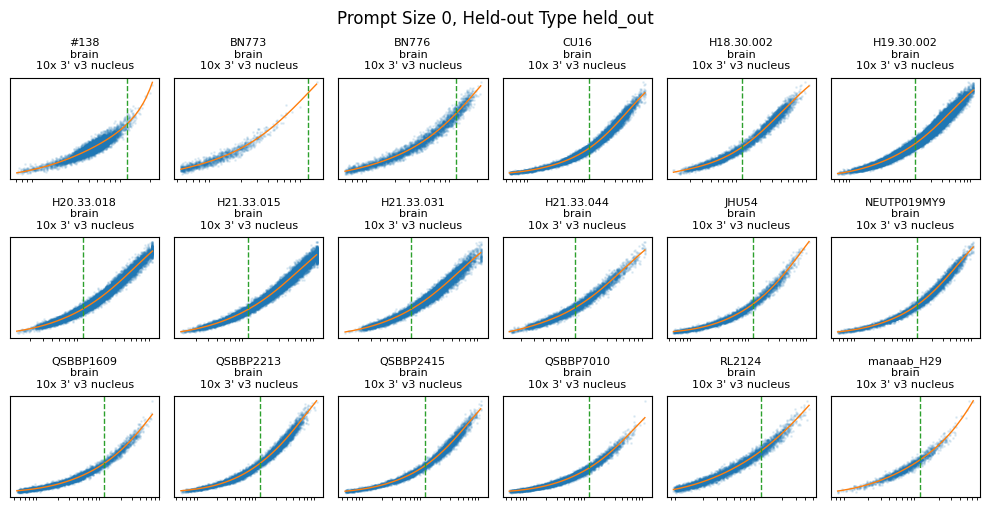

In [67]:
held_out_type = "held_out"
model_name = "10M_001_bs1536"
coarse_tissue_label = "brain"
assay = "10x 3' v3"
suspension_type = "nucleus"
prompt_size = 0
df = HELD_OUT_DATA[held_out_type][model_name][prompt_size]
df_subset = df[
    (df["coarse_tissue_label"] == coarse_tissue_label)
    & (df["assay_label"] == assay)
    & (df["suspension_type_label"] == suspension_type)
]
median_lib_size = results_df[
    (results_df["held_out_type"] == held_out_type)
    & (results_df["model_name"] == model_name)
    & (results_df["prompt_size"] == prompt_size)
    & (results_df["coarse_tissue_label"] == coarse_tissue_label)
    & (results_df["assay"] == assay)
    & (results_df["suspension_type"] == suspension_type)
]["median_lib_size"].values[0]
plt.figure(figsize=(10, 10))
# iterate over unique combinations
i = 0
for donor_id in UNIQUE_COMBINATIONS[held_out_type].loc[(coarse_tissue_label, assay, suspension_type)].index:
    df_donor_subset = df_subset[df_subset["donor_id"] == donor_id]
    df_donor_subset = df_donor_subset.sort_values("total_mrna_umis_downsampled")
    plt.subplot(6, 6, i + 1)
    # Set title with cell type and R²
    plt.title(f"{donor_id}\n{coarse_tissue_label}\n{assay} {suspension_type}", fontsize=8)
    plt.scatter(df_donor_subset["total_mrna_umis_downsampled"], df_donor_subset["gene_value"], s=1, alpha=0.1)
    plt.plot(df_donor_subset["total_mrna_umis_downsampled"], df_donor_subset["predicted_gene_value"], "-", color="C1", linewidth=1)
    plt.axvline(x=median_lib_size, color="C2", linestyle="--", linewidth=1)
    plt.xscale("log")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(None)
    i += 1
plt.suptitle(f"Prompt Size {prompt_size}, Held-out Type {held_out_type}")
plt.tight_layout()
plt.show()

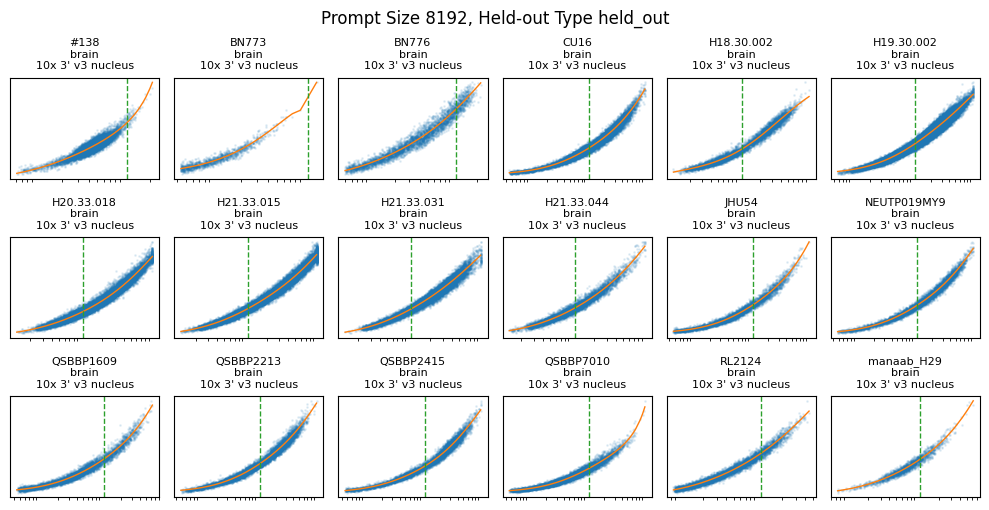

In [68]:
held_out_type = "held_out"
model_name = "10M_001_bs1536"
coarse_tissue_label = "brain"
assay = "10x 3' v3"
suspension_type = "nucleus"
prompt_size = 8192
df = HELD_OUT_DATA[held_out_type][model_name][prompt_size]
df_subset = df[
    (df["coarse_tissue_label"] == coarse_tissue_label)
    & (df["assay_label"] == assay)
    & (df["suspension_type_label"] == suspension_type)
]
median_lib_size = results_df[
    (results_df["held_out_type"] == held_out_type)
    & (results_df["model_name"] == model_name)
    & (results_df["prompt_size"] == prompt_size)
    & (results_df["coarse_tissue_label"] == coarse_tissue_label)
    & (results_df["assay"] == assay)
    & (results_df["suspension_type"] == suspension_type)
]["median_lib_size"].values[0]
plt.figure(figsize=(10, 10))
# iterate over unique combinations
i = 0
for donor_id in UNIQUE_COMBINATIONS[held_out_type].loc[(coarse_tissue_label, assay, suspension_type)].index:
    df_donor_subset = df_subset[df_subset["donor_id"] == donor_id]
    df_donor_subset = df_donor_subset.sort_values("total_mrna_umis_downsampled")
    plt.subplot(6, 6, i + 1)
    # Set title with cell type and R²
    plt.title(f"{donor_id}\n{coarse_tissue_label}\n{assay} {suspension_type}", fontsize=8)
    plt.scatter(df_donor_subset["total_mrna_umis_downsampled"], df_donor_subset["gene_value"], s=1, alpha=0.1)
    plt.plot(df_donor_subset["total_mrna_umis_downsampled"], df_donor_subset["predicted_gene_value"], "-", color="C1", linewidth=1)
    plt.axvline(x=median_lib_size, color="C2", linestyle="--", linewidth=1)
    plt.xscale("log")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(None)
    i += 1
plt.suptitle(f"Prompt Size {prompt_size}, Held-out Type {held_out_type}")
plt.tight_layout()
plt.show()

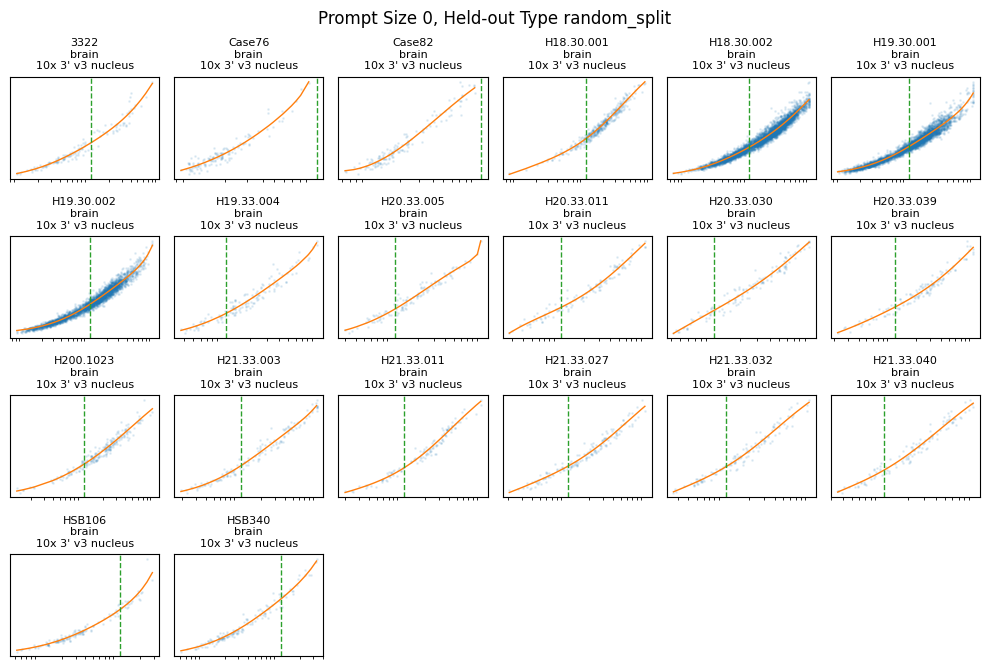

In [69]:
held_out_type = "random_split"
model_name = "10M_001_bs1536"
coarse_tissue_label = "brain"
assay = "10x 3' v3"
suspension_type = "nucleus"
prompt_size = 0
df = HELD_OUT_DATA[held_out_type][model_name][prompt_size]
df_subset = df[
    (df["coarse_tissue_label"] == coarse_tissue_label)
    & (df["assay_label"] == assay)
    & (df["suspension_type_label"] == suspension_type)
]
median_lib_size = results_df[
    (results_df["held_out_type"] == held_out_type)
    & (results_df["model_name"] == model_name)
    & (results_df["prompt_size"] == prompt_size)
    & (results_df["coarse_tissue_label"] == coarse_tissue_label)
    & (results_df["assay"] == assay)
    & (results_df["suspension_type"] == suspension_type)
]["median_lib_size"].values[0]
plt.figure(figsize=(10, 10))
# iterate over unique combinations
i = 0
for donor_id in UNIQUE_COMBINATIONS[held_out_type].loc[(coarse_tissue_label, assay, suspension_type)].index:
    df_donor_subset = df_subset[df_subset["donor_id"] == donor_id]
    df_donor_subset = df_donor_subset.sort_values("total_mrna_umis_downsampled")
    plt.subplot(6, 6, i + 1)
    # Set title with cell type and R²
    plt.title(f"{donor_id}\n{coarse_tissue_label}\n{assay} {suspension_type}", fontsize=8)
    plt.scatter(df_donor_subset["total_mrna_umis_downsampled"], df_donor_subset["gene_value"], s=1, alpha=0.1)
    plt.plot(df_donor_subset["total_mrna_umis_downsampled"], df_donor_subset["predicted_gene_value"], "-", color="C1", linewidth=1)
    plt.axvline(x=median_lib_size, color="C2", linestyle="--", linewidth=1)
    plt.xscale("log")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(None)
    i += 1
plt.suptitle(f"Prompt Size {prompt_size}, Held-out Type {held_out_type}")
plt.tight_layout()
plt.show()

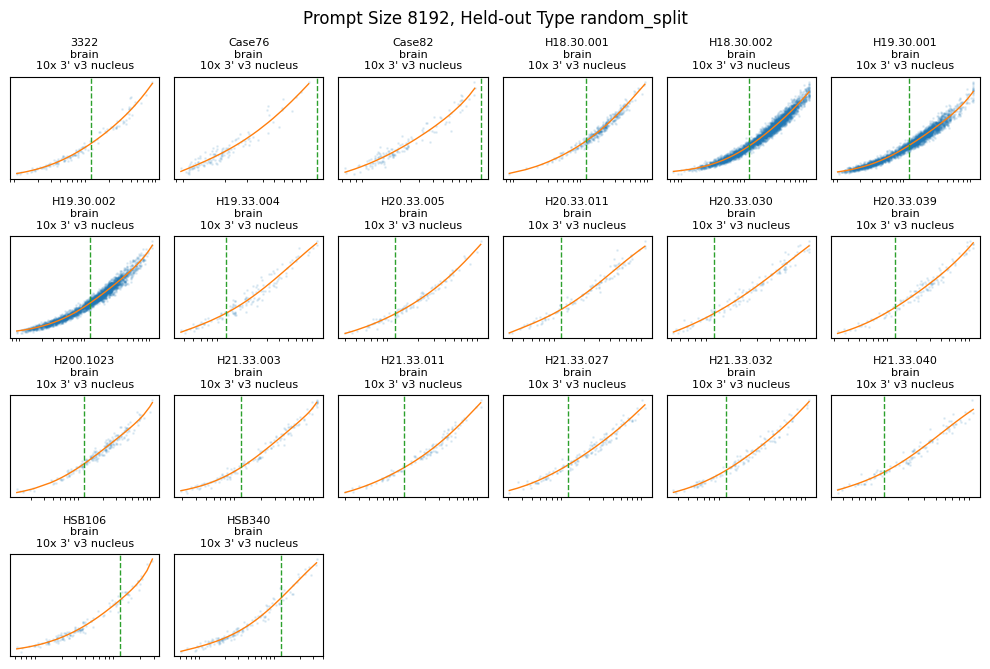

In [70]:
held_out_type = "random_split"
model_name = "10M_001_bs1536"
coarse_tissue_label = "brain"
assay = "10x 3' v3"
suspension_type = "nucleus"
prompt_size = 8192
df = HELD_OUT_DATA[held_out_type][model_name][prompt_size]
df_subset = df[
    (df["coarse_tissue_label"] == coarse_tissue_label)
    & (df["assay_label"] == assay)
    & (df["suspension_type_label"] == suspension_type)
]
median_lib_size = results_df[
    (results_df["held_out_type"] == held_out_type)
    & (results_df["model_name"] == model_name)
    & (results_df["prompt_size"] == prompt_size)
    & (results_df["coarse_tissue_label"] == coarse_tissue_label)
    & (results_df["assay"] == assay)
    & (results_df["suspension_type"] == suspension_type)
]["median_lib_size"].values[0]
plt.figure(figsize=(10, 10))
# iterate over unique combinations
i = 0
for donor_id in UNIQUE_COMBINATIONS[held_out_type].loc[(coarse_tissue_label, assay, suspension_type)].index:
    df_donor_subset = df_subset[df_subset["donor_id"] == donor_id]
    df_donor_subset = df_donor_subset.sort_values("total_mrna_umis_downsampled")
    plt.subplot(6, 6, i + 1)
    # Set title with cell type and R²
    plt.title(f"{donor_id}\n{coarse_tissue_label}\n{assay} {suspension_type}", fontsize=8)
    plt.scatter(df_donor_subset["total_mrna_umis_downsampled"], df_donor_subset["gene_value"], s=1, alpha=0.1)
    plt.plot(df_donor_subset["total_mrna_umis_downsampled"], df_donor_subset["predicted_gene_value"], "-", color="C1", linewidth=1)
    plt.axvline(x=median_lib_size, color="C2", linestyle="--", linewidth=1)
    plt.xscale("log")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(None)
    i += 1
plt.suptitle(f"Prompt Size {prompt_size}, Held-out Type {held_out_type}")
plt.tight_layout()
plt.show()

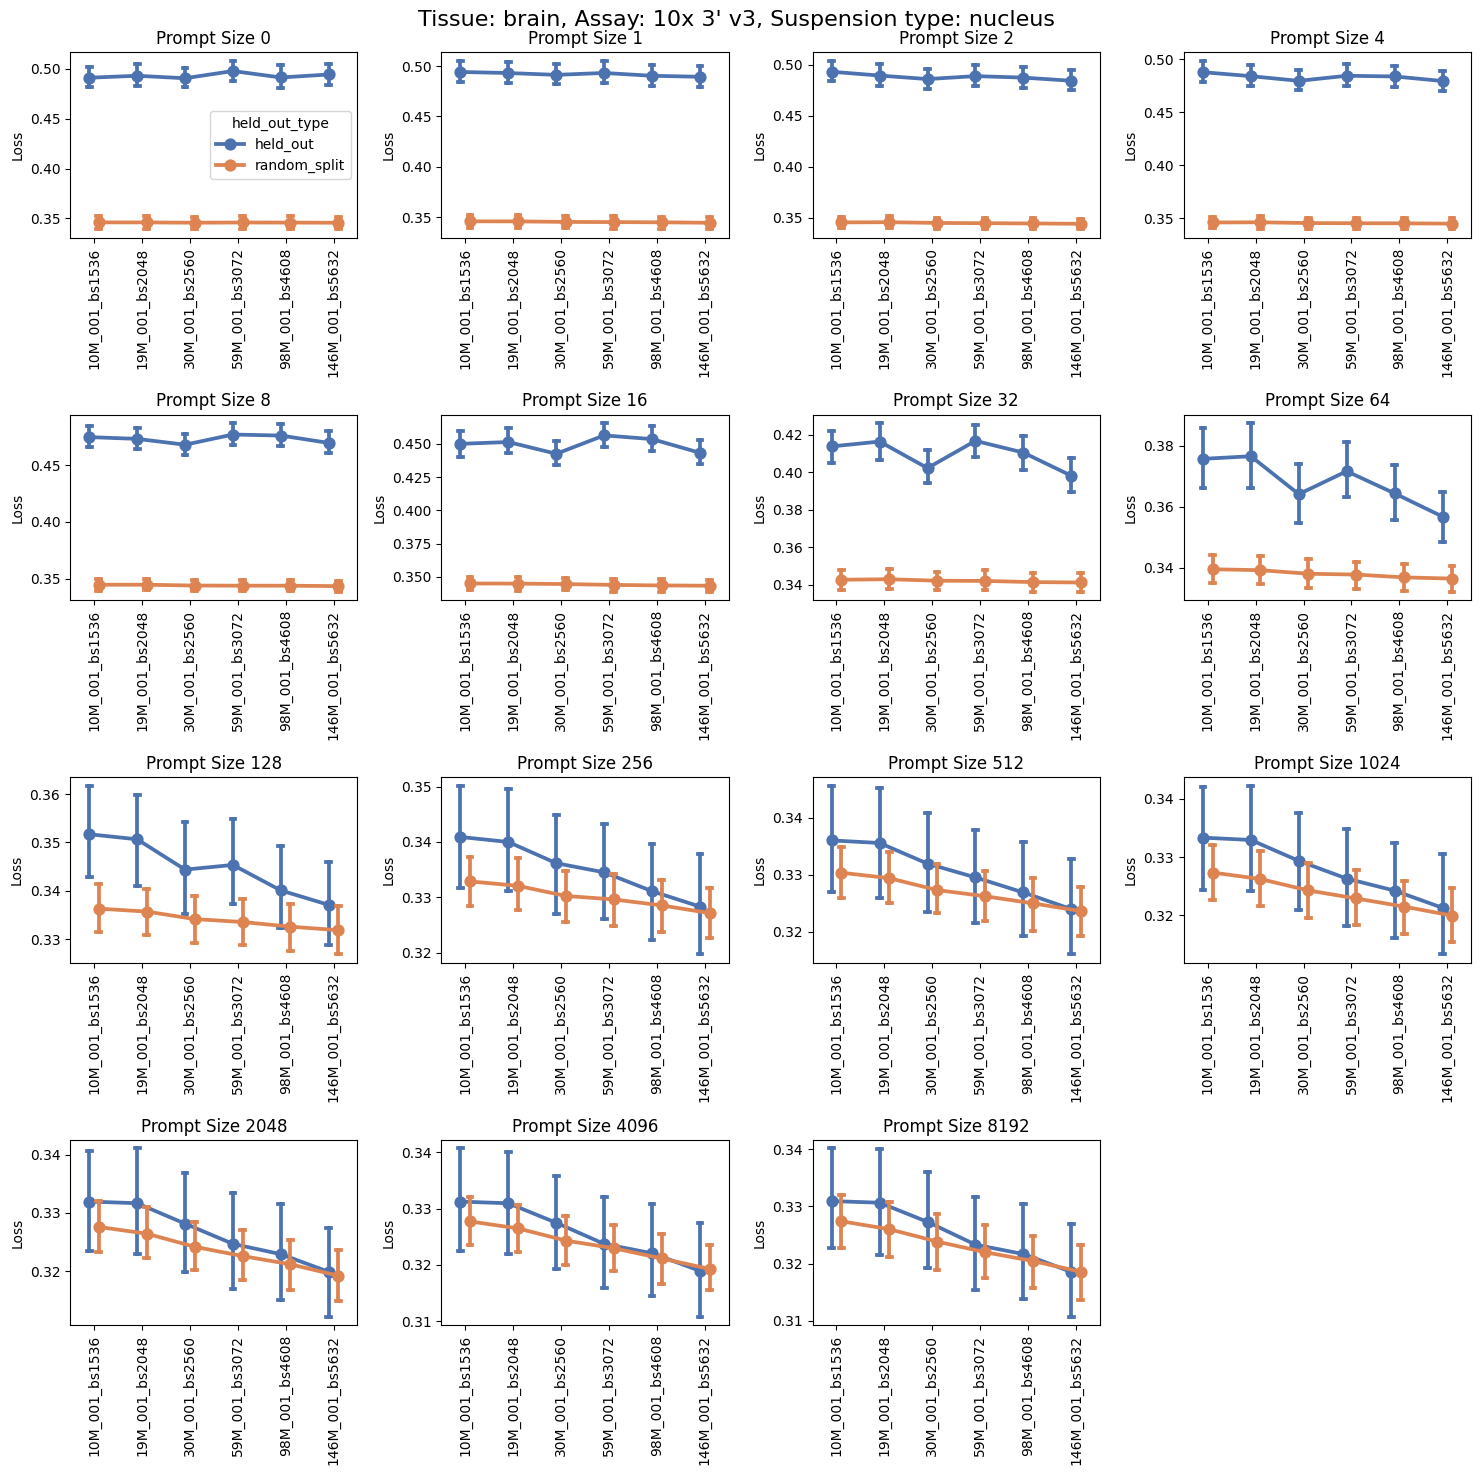

In [71]:
coarse_tissue_label = "brain"
assay = "10x 3' v3"
suspension_type = "nucleus"
plt.figure(figsize=(15, 15))
for i, prompt_size in enumerate(PROMPT_SIZES):
    plt.subplot(4, 4, i + 1)
    df = results_df[
        (results_df["coarse_tissue_label"] == coarse_tissue_label)
        & (results_df["assay"] == assay)
        & (results_df["suspension_type"] == suspension_type)
        & (results_df["prompt_size"] == prompt_size)
    ]
    # donor_id not in ["BN773", "Case76", "Case82"]
    df = df[~df["donor_id"].isin(["BN773", "Case76", "Case82"])]
    df["1+P"] = df["prompt_size"] + 1
    sns.pointplot(data=df, x="model_name", y="median_loss", hue="held_out_type", legend=i==0, palette="deep", dodge=0.2, capsize=0.1)
    plt.ylabel("Loss")
    plt.xlabel(None)
    # rotate xlabels
    plt.xticks(rotation=90)
    plt.title(f"Prompt Size {prompt_size}")
plt.suptitle(f"Tissue: {coarse_tissue_label}, Assay: {assay}, Suspension type: {suspension_type}", fontsize=16)
plt.tight_layout()
plt.show()

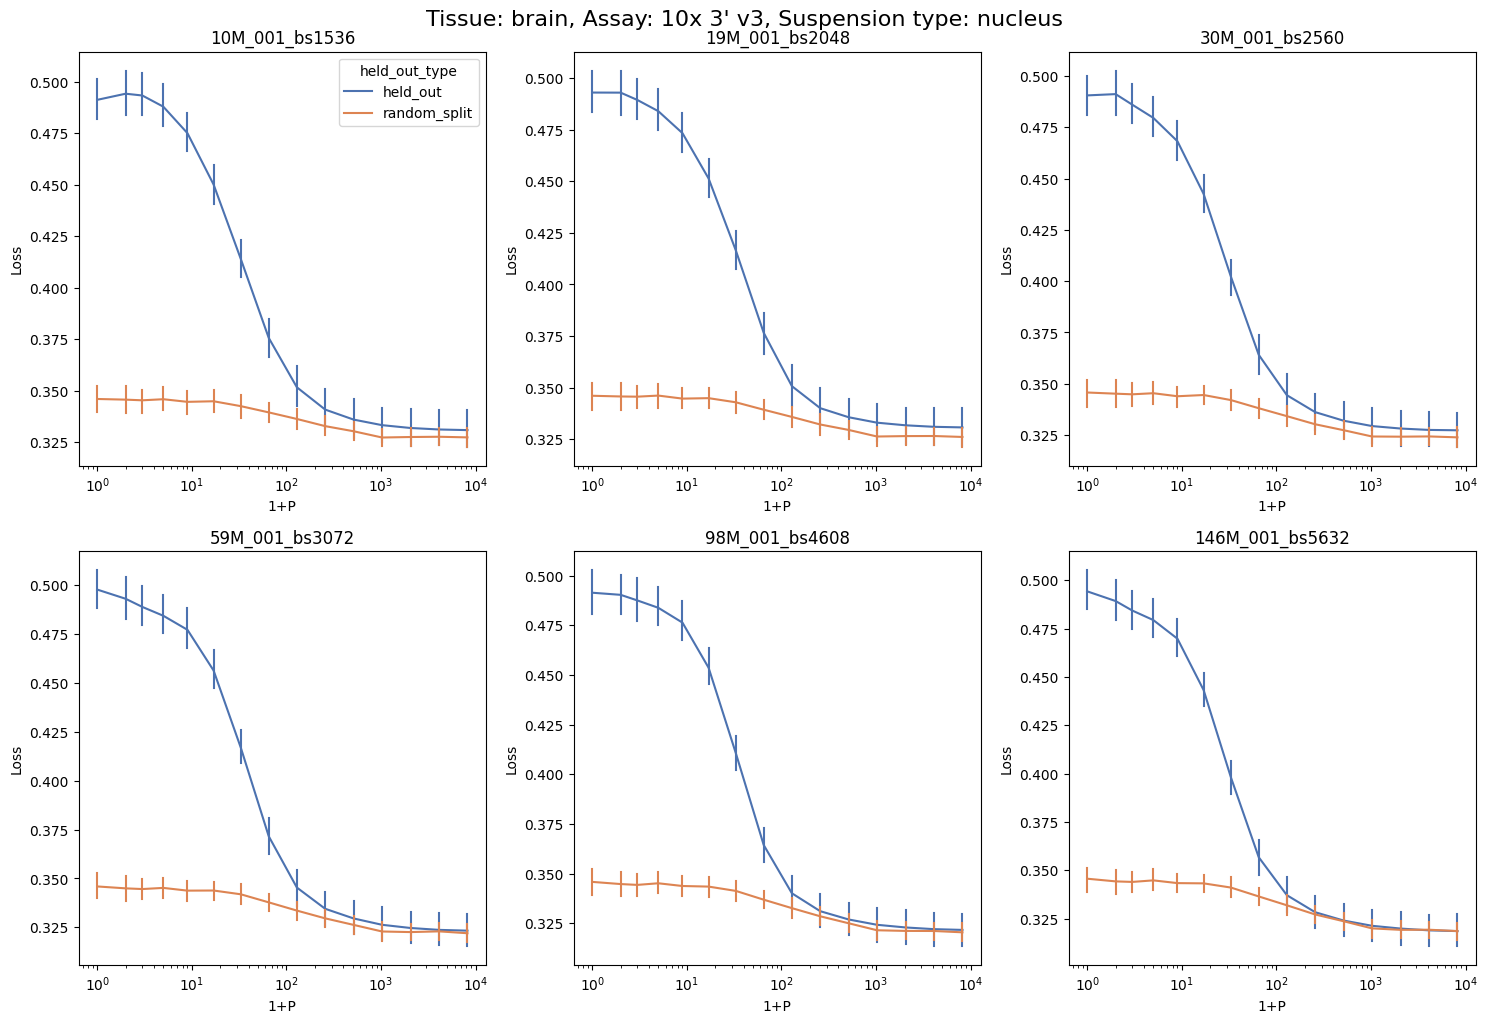

In [72]:
coarse_tissue_label = "brain"
assay = "10x 3' v3"
suspension_type = "nucleus"
plt.figure(figsize=(15, 15))
for i, model_name in enumerate(MODEL_NAMES):
    plt.subplot(3, 3, i + 1)
    df = results_df[
        (results_df["coarse_tissue_label"] == coarse_tissue_label)
        & (results_df["assay"] == assay)
        & (results_df["suspension_type"] == suspension_type)
        & (results_df["model_name"] == model_name)
    ]
    # donor_id not in ["BN773", "Case76", "Case82"]
    df = df[~df["donor_id"].isin(["BN773", "Case76", "Case82"])]
    df["1+P"] = df["prompt_size"] + 1
    sns.lineplot(data=df, x="1+P", y="median_loss", hue="held_out_type", legend=i==0, palette="deep", err_style="bars")
    plt.ylabel("Loss")
    plt.xscale("log")
    plt.title(model_name)
plt.suptitle(f"Tissue: {coarse_tissue_label}, Assay: {assay}, Suspension type: {suspension_type}", fontsize=16)
plt.tight_layout()
plt.show()

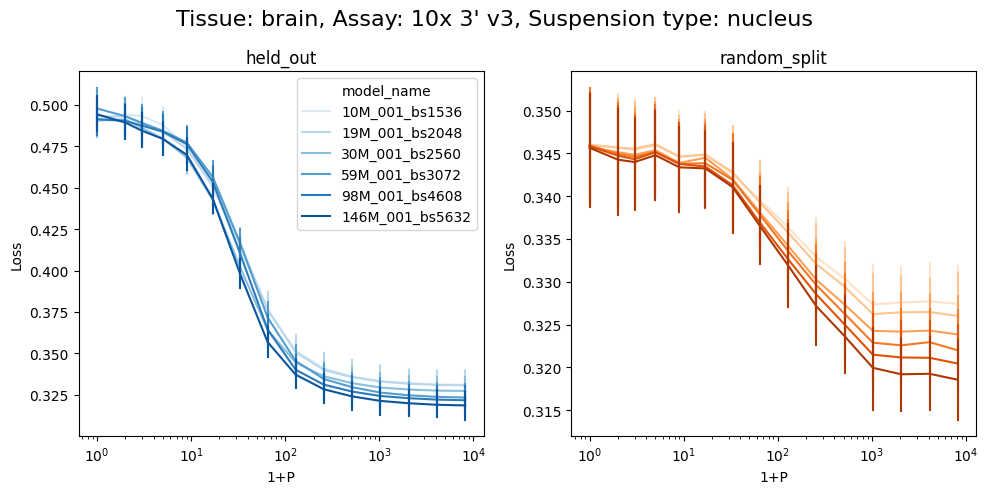

In [73]:
palette = {
    "held_out": "Blues",
    "random_split": "Oranges",
}
coarse_tissue_label = "brain"
assay = "10x 3' v3"
suspension_type = "nucleus"
plt.figure(figsize=(10, 5))
for i, held_out_type in enumerate(HELD_OUT_TYPES):
    plt.subplot(1, 2, i + 1)
    df = results_df[
        (results_df["coarse_tissue_label"] == coarse_tissue_label)
        & (results_df["assay"] == assay)
        & (results_df["suspension_type"] == suspension_type)
        & (results_df["held_out_type"] == held_out_type)
    ]
    # donor_id not in ["BN773", "Case76", "Case82"]
    df = df[~df["donor_id"].isin(["BN773", "Case76", "Case82"])]
    df["1+P"] = df["prompt_size"] + 1
    sns.lineplot(data=df, x="1+P", y="median_loss", hue="model_name", legend=i==0, err_style="bars", palette=palette[held_out_type])
    plt.ylabel("Loss")
    plt.xscale("log")
    plt.title(held_out_type)
plt.suptitle(f"Tissue: {coarse_tissue_label}, Assay: {assay}, Suspension type: {suspension_type}", fontsize=16)
plt.tight_layout()
plt.show()

In [77]:
results_df["short_model_name"] = results_df["model_name"].map(dict(zip(MODEL_NAMES, SHORT_MODEL_NAMES)))

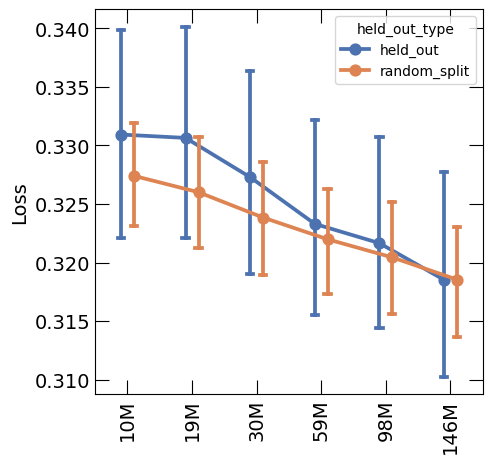

In [79]:
coarse_tissue_label = "brain"
assay = "10x 3' v3"
suspension_type = "nucleus"
prompt_size = 8192
plt.figure(figsize=(5, 5))
df = results_df[
    (results_df["coarse_tissue_label"] == coarse_tissue_label)
    & (results_df["assay"] == assay)
    & (results_df["suspension_type"] == suspension_type)
    & (results_df["prompt_size"] == prompt_size)
]
# donor_id not in ["BN773", "Case76", "Case82"]
df = df[~df["donor_id"].isin(["BN773", "Case76", "Case82"])]
df["1+P"] = df["prompt_size"] + 1
sns.pointplot(data=df, x="short_model_name", y="median_loss", hue="held_out_type", legend=True, palette="deep", dodge=0.2, capsize=0.1)
plt.ylabel("Loss", fontsize=14)
plt.xlabel(None)
# rotate xlabels
plt.xticks(rotation=90)
plt.tick_params(labelsize=14)
plt.tick_params(direction="in", which="major", length=10, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction="in", which="minor", length=5, bottom=True, top=True, left=True, right=True)
# put legend outside
plt.show()